In [12]:
import verde as vd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cartopy as ccrs

In [10]:
##5:GRID_EAST, 6:GRID_NORTH, 7:STATION_ELEV, 17:BOUGUER_ANOMALY
fp='./Data/landgrav_ss.csv'
dat=np.genfromtxt(fp,delimiter=",",skip_header=1,usecols=(5,6,17))
dat

array([[2.5880e+05, 5.5859e+05, 9.3300e+00],
       [2.4216e+05, 5.5831e+05, 1.0860e+01],
       [2.6052e+05, 5.4712e+05, 2.2930e+01],
       ...,
       [2.4324e+05, 6.1980e+05, 1.1390e+01],
       [2.3755e+05, 6.1583e+05, 1.6240e+01],
       [2.5383e+05, 6.3865e+05, 1.6210e+01]])

In [14]:
east = dat[:,0]
north = dat[:,1]
boug = dat[:,2]

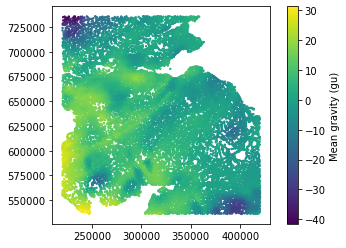

In [22]:
fig, ax = plt.subplots()
scatter = ax.scatter(east, north, c=boug, s=2)
ax.set_aspect('equal')
fig.colorbar(scatter, label='Mean gravity (gu)')

In [24]:
#Use Verde to make grid
nx = 256 #Number of points in x 
ny = 256 #Number of points in y
sqsize=180000   ### Size of square in metres
emin=220000     ### Easting of SW corner
emax=emin+sqsize
nmin=559000     ### Northing of SW corner
nmax=nmin+sqsize

W, E, S, N = 220000, 220000+180000, 559000, 559000+180000
region = (W, E, S, N)


In [25]:
easting, northing = vd.grid_coordinates(region = region, shape=(nx, ny))

In [129]:
#Interpolating the data
grd = vd.ScipyGridder(method='nearest').fit((east, north), boug)

In [130]:
#Gridding the data
grid = grd.grid(region = region, shape=(nx, ny), data_names='Gravity (gu)')

In [131]:
type(grid)

xarray.core.dataset.Dataset

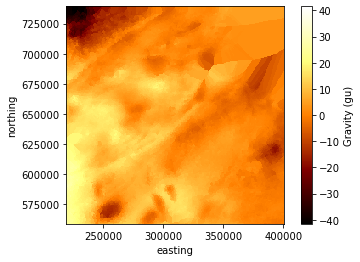

In [132]:
cmap = plt.cm.afmhot

fig, ax = plt.subplots()
grid['Gravity (gu)'].plot.pcolormesh(ax=ax, cmap=cmap)
ax.set_aspect('equal')


In [133]:
#mask based on the data being more then 2 grid spacings.
mask = vd.distance_mask(data_coordinates=(east, north), grid=grid, maxdist=3*(sqsize/nx))

Text(0.5, 1.0, 'Cubic interpolated Scotland Gravity data')

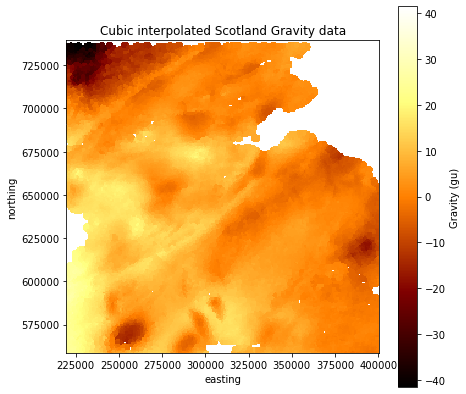

In [134]:
#Plot the masked data
fig, ax = plt.subplots(figsize=(7,7),)
mask['Gravity (gu)'].plot.pcolormesh(ax=ax, cmap=cmap)
ax.set_aspect('equal')
ax.set_title('Cubic interpolated Scotland Gravity data')


C:\Users\lewis\Anaconda3\envs\gis\lib\site-packages\cartopy\mpl\geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
C:\Users\lewis\Anaconda3\envs\gis\lib\site-packages\cartopy\mpl\geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


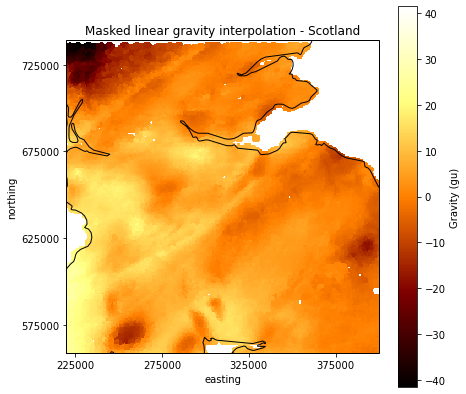

In [164]:
xticks = np.arange(225000, 400000, 50000)
yticks = np.arange(575000,775000, 50000)

fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.crs.OSGB())
mask['Gravity (gu)'].plot.pcolormesh(cmap=cmap)
ax.coastlines(resolution='10m')
ax.set_xlim((W, E))
ax.set_ylim((S, N))
ax.set_title('Masked linear gravity interpolation - Scotland')
#ax.gridlines(crs=ccrs.crs.OSGB())

ax.set_xticks(xticks)
ax.set_yticks(yticks)

fp='./Figures/ScotlandGrav/linear_interp.png'
fig.savefig(fp, dpi=300, bbox_inches='tight')